## Using Deep Learning in Python to classify Land Use Land Use Land Cover on Remote Sensing Satellite data

In [ ]:
### Libraries

In [ ]:
location = 'dataset/'

from IPython.core.display import display, HTML
from IPython.display import display_html
display(  HTML( '<style>.container { width:60% !important; }</style>' )  )

import os, random, time, datetime
import pandas as pd, re
import numpy as np,  seaborn as sns
from numpy import savetxt
from numpy import genfromtxt
import sklearn, scipy
from sklearn import *
import missingno as msno

from glob import glob
from scipy.io import loadmat

import scipy.stats as stats, random, math

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import *
from matplotlib.colors import ListedColormap

plt.style.use('classic')

# import remote sensing libraries
import geopandas as pdd
import rasterio as rio, shapely
import earthpy.plot as ep
from osgeo import gdal


# ml ai lib 
import tensorflow as tf, imageio, PIL
from tensorflow import *
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers
from tensorflow.keras.layers import *
from tensorflow.keras import models
from tensorflow.keras.callbacks import *
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split

%matplotlib inline

## Set Jupyter notebook display options for pandas
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 6

<br> 

### Data preparation

The below table shows the general band information that includes wavelength and spectral resolution.
<br>

In [3]:
sen_df = pd.read_csv( 'dataset/sentinel_2_band_details.csv', index_col= [0] )
sen_df

,Name,Cental Wavelenth(micro meters),Resolution(meters)
Band No,,,
1,Coastal aerosol,0.443,60
2,Blue,0.490,10
3,Green,0.560,10
...,...,...,...
10,SWIR-Cirrus,1.375,60
11,SWIR,1.610,20
12,SWIR,2.190,20


#### Read Raster Data


let’s read the 12 bands of the satellite data using and stack them into an n-dimensional array using. The resultant data after stacking will have the shape (12, 954, 298). We also have the ground truth of the satellite data (i.e. y label). The ground truth has 6 classes which include water, plants, trees, bare land, etc.

In [4]:
sen_bands = glob(  pathname= 'dataset/sundarbans_data/*B?*.tiff'  )

sen_bands.sort();   sen_bands

['dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B01_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B02_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B03_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B04_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B05_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B06_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B07_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B08_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B09_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-2_L2A_B11_(Raw).tiff',
 'dataset/sundarbans_data\\2020-01-27-00_00_2020-01-27-23_59_Sentinel-

In [5]:
# parse data and merge them as a raster layer band

raster_band_ls = []

for e_raster_file in sen_bands:
    with rio.open(  fp= e_raster_file, mode= 'r' ) as raster_band_temp:
        raster_band_ls.append( raster_band_temp.read(1) )

In [6]:
# convert/stack the list into np array to -->  # dim, # row, # col

print( type(raster_band_ls), len(raster_band_ls), raster_band_ls[1].shape )

raster_band_arr =  np.stack( raster_band_ls )

print( type(raster_band_arr), len(raster_band_arr), raster_band_arr.shape )

<class 'list'> 12 (954, 298)
<class 'numpy.ndarray'> 12 (12, 954, 298)


In [162]:
# label
scipy.io.loadmat( 'dataset/sundarbans_data/Sundarbands_gt.mat' )

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Fri Mar  5 04:31:49 2021',
 '__version__': '1.0',
 '__globals__': [],
 'gt': array([[0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        [0, 0, 0, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]])}

In [7]:
# label

yi_1 = scipy.io.loadmat( 'dataset/sundarbans_data/Sundarbands_gt.mat' )['gt'] 
yi_1

array([[0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])


### Data Visualization

*[Go to top](#toc)*


These Resmote Sensing satellite data have multiple numbers of bands containing the data ranging from visible to infrared. The infrared is not visible to human eye. The help of an RGB Composite Image makes it easier to understand the data effectively.

To plot RGB composite images, Using red, green, and blue bands (bands 4, 3, & 2) we can visualize the composite image. 

In [ ]:
from matplotlib.colors import ListedColormap

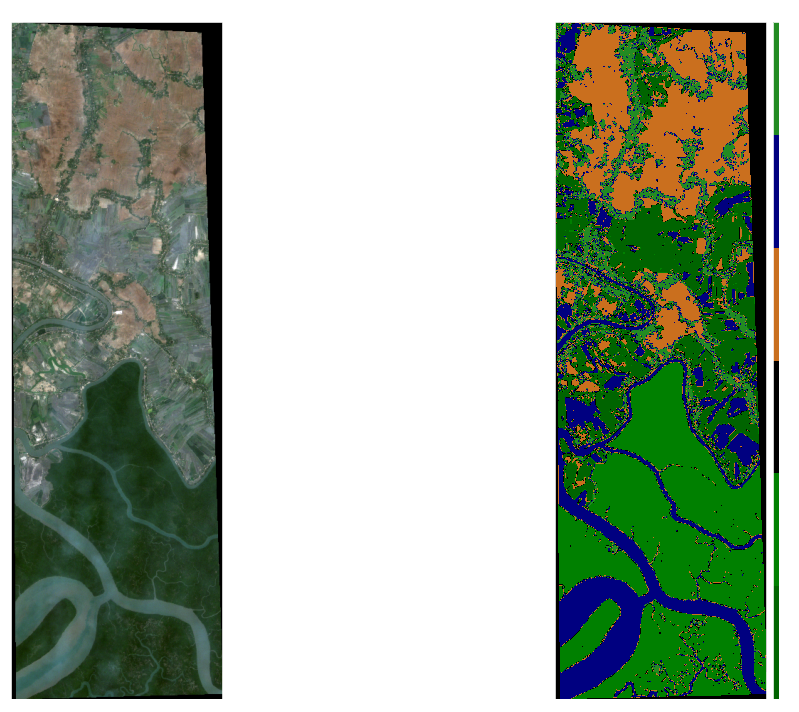

In [10]:
fg, ax = plt.subplots( 1,2, figsize= ( 20, 10 ) )

ep.plot_rgb(  arr= raster_band_arr,
              rgb= (3,2,1), stretch= True, str_clip= 0.02,
              figsize=(8,10), title= 'RGB Composite of a Satellite Image', ax= ax[0]   )

yi_1 = loadmat( 'dataset/sundarbans_data/Sundarbands_gt.mat' )['gt'] 

ep.plot_bands(  yi_1,
                cmap= ListedColormap( colors= ['darkgreen', 'green', 'black','#CA6F1E', 'navy', 'forestgreen'] ), ax= ax[1]  )

plt.tight_layout(); plt.show()

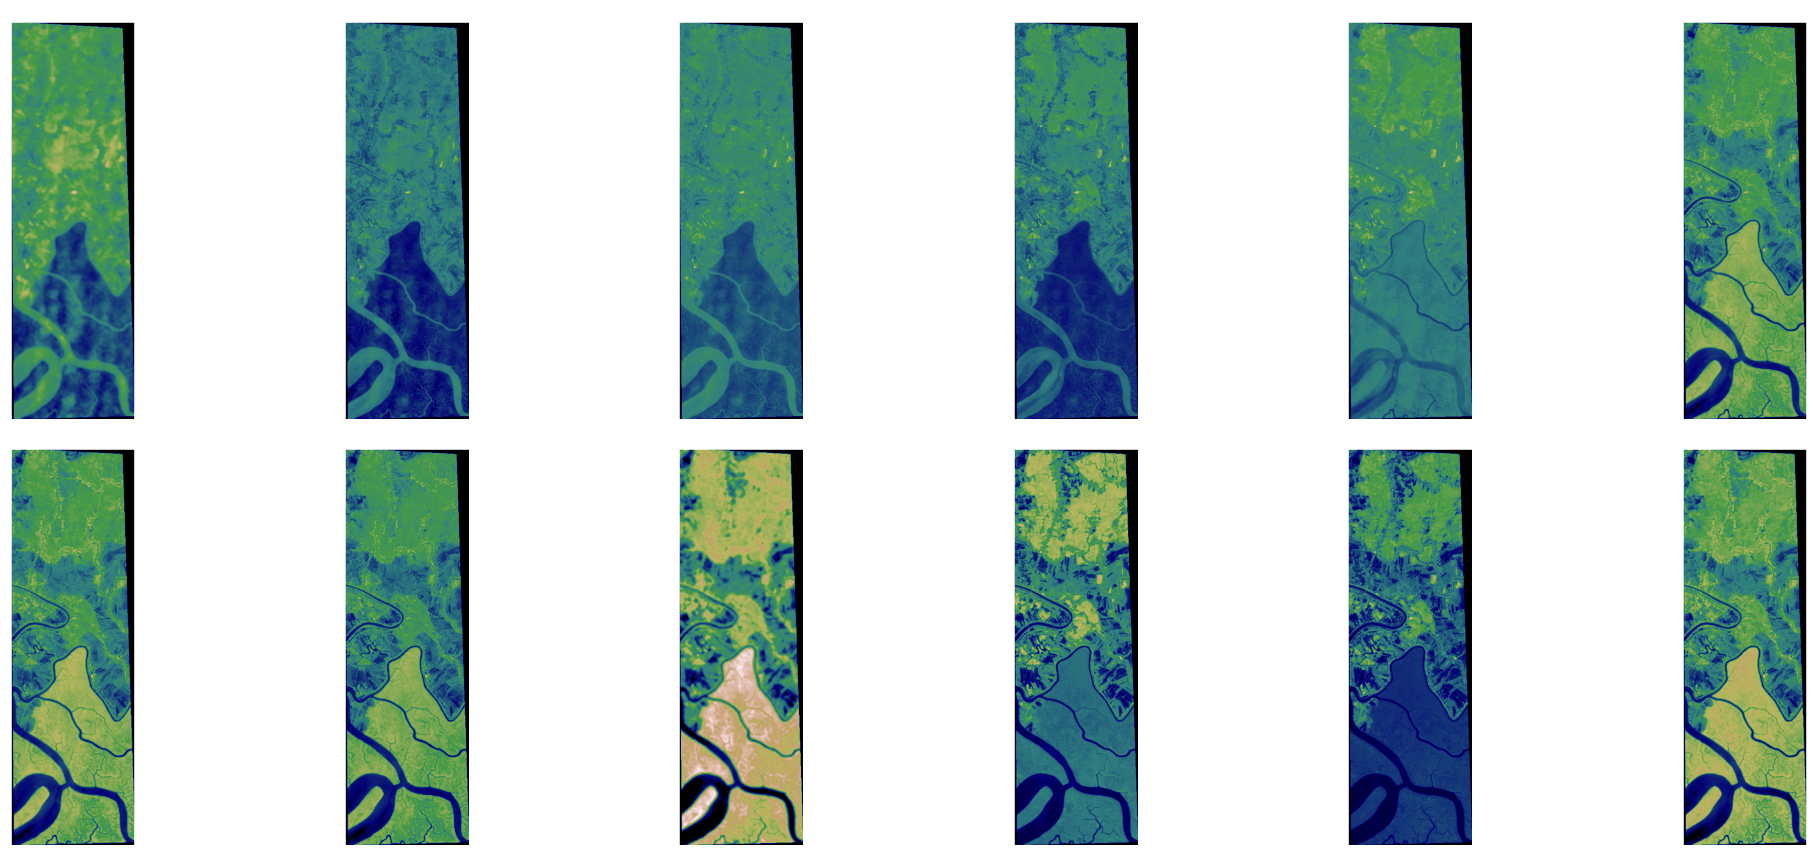

<Figure size 432x288 with 0 Axes>

In [11]:
# visualize all 12 bands
ep.plot_bands(  arr= raster_band_arr, cmap= 'gist_earth', cols= 6, cbar= False, figsize= (30,12)   )
plt.tight_layout()

<br>

###  Data preprocessing 

*[Go to top](#toc)*

Let’s create three-dimensional patches of the Sundarbans satellite image by applying Principal Component Analysis (PCA) to the data.

The below code is used to create functions for implementing PCA and creating 3D patches which will be our input to CNN.
<br>

In [12]:
raster_band_arr_xyD =  np.moveaxis(  raster_band_arr, 0, -1  )
print( f'Shape of a Raster in the form x, y, D : {raster_band_arr_xyD.shape}' )

# flatten the 1st two components i.e. x & y
raster_flatten_arr = raster_band_arr_xyD.reshape(  ( -1, raster_band_arr_xyD.shape[-1] )  )
print( f'Shape of a flattened Raster: {raster_flatten_arr.shape}' )

# PCA from 12 components to 5
num_pca_comp = 5

pca_obj = sklearn.decomposition.PCA( n_components= num_pca_comp, whiten= True )
pc_flattened = pca_obj.fit_transform( raster_flatten_arr )
print(  f'Shape of a PC: {pc_flattened.shape}' )

# change flattened PCs into x, y, D
pc_xyD = pc_flattened.reshape(   ( raster_band_arr_xyD.shape[0], raster_band_arr_xyD.shape[1], 5  )   )
print(  f'Shape of a PC in the form x, y, D :: {pc_xyD.shape}' )

Shape of a Raster in the form x, y, D : (954, 298, 12)
Shape of a flattened Raster: (284292, 12)
Shape of a PC: (284292, 5)
Shape of a PC in the form x, y, D :: (954, 298, 5)


In [13]:
# func Create 3D Patches

def padWithZeros( X, margin= 2 ):
    newX = np.zeros(   shape= ( X.shape[0] + 2 * margin, X.shape[1] + 2 * margin, X.shape[2] )  )
    x_offset, y_offset = margin, margin
    newX[ x_offset:X.shape[0] + x_offset, y_offset:X.shape[1] + y_offset, : ] = X
    return newX

def createImageCubes( X, y, windowSize= 5, removeZeroLabels= False ):
    margin = int((windowSize - 1) / 2)
    zeroPaddedX = padWithZeros(X, margin=margin)
    # split patches
    patchesData = np.zeros((X.shape[0] * X.shape[1], windowSize, windowSize, X.shape[2]))
    patchesLabels = np.zeros((X.shape[0] * X.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = y[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [14]:
# global variables

dataset = 'SB'
model_nm = 'lulc_deepNN'
win_sz = 15

In [15]:
# create 3D Patches

# change flattened PCs into x, y, D
pc_xyD = pc_flattened.reshape(   
                                    (  raster_band_arr_xyD.shape[0], raster_band_arr_xyD.shape[1], num_pca_comp  )
                             )
print(  f'Shape of a PC in the form x, y, D :: {pc_xyD.shape}' )

yi_1 = loadmat( 'dataset/sundarbans_data/Sundarbands_gt.mat' )['gt'] 

x_3D_patch, y_3D_patch = createImageCubes(  X= pc_xyD, y= yi_1, windowSize= win_sz, removeZeroLabels= False  )
print(  f'Patch size: {x_3D_patch.shape}, {y_3D_patch.shape}'  )

Shape of a PC in the form x, y, D :: (954, 298, 5)
Patch size: (284292, 15, 15, 5), (284292,)


In [22]:
# train test split

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(  x_3D_patch, y_3D_patch, test_size= 30./100  )
print(  f'xtrn & ytrn size: {xtrn.shape}, {ytrn.shape}'  )

ytrn_ori = ytrn.copy()

# expand one dimension 

xtrn = np.expand_dims(  xtrn, axis= -1  );                 xtst = np.expand_dims(  xtst, axis= -1  )

print(  f'xtrn & xtst size: {xtrn.shape}, {xtst.shape}'  )

## one hot encoding
ytrn = keras.utils.to_categorical( ytrn );                  ytst = keras.utils.to_categorical( ytst )

print(  f'ytrn before & after OHE: {ytrn_ori.shape}, {ytrn.shape}'  );  ytrn

xtrn & ytrn size: (199004, 15, 15, 5), (199004,)
xtrn & xtst size: (199004, 15, 15, 5, 1), (85288, 15, 15, 5, 1)
ytrn before & after OHE: (199004,), (199004, 6)


array([[0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)

<br><br>

### Developing Neural Network Architecture

*[Go to top](#toc)*

Let's build a 3 dimensional CNN with multiple layers such as Convolution, Dropout, and Dense Layers for land cover classification.

In [31]:
# output layer shape
op_lyr_shp = ytrn.shape[1]

## input layer shape
ip_lyr_shp = keras.Input(  shape= ( win_sz, win_sz, num_pca_comp, 1 )   )
print( f'Input layer shape --> {ip_lyr_shp.shape}' )

Input layer shape --> (None, 15, 15, 5, 1)


In [70]:
## model arch

cnn_lyr1 = Conv3D(  filters= 16, kernel_size= (2,2,3), activation= 'relu'  )( ip_lyr_shp )
print( f'lyr 1 --> {cnn_lyr1.shape}' )

cnn_lyr2 = Conv3D(  filters= 32, kernel_size= (2,2,3), activation= 'relu'  )(cnn_lyr1)
print( f'lyr 2 --> {cnn_lyr2.shape}' )

cnn_lyr3 = Conv3D(  filters= 64, kernel_size= (2,2,1), activation= 'relu'  )( cnn_lyr2 )
print( f'lyr 3 --> {cnn_lyr3.shape}' )

cnn_lyr4 = Conv3D(  filters= 64, kernel_size= (2,2,1), activation= 'relu'  )( cnn_lyr3 )
print( f'lyr 4 --> {cnn_lyr4.shape}' )

# # flatten the cnn layer

flatten_lyr = Flatten( )( cnn_lyr4 )
print( f'flatten_lyr --> {flatten_lyr.shape}' )

# Dense lyr
dense_lyr1 = Dense(  units= 128, activation= 'relu'  )( flatten_lyr )
drp_lyr1 = Dropout(  rate= 40./100  )( dense_lyr1 )

dense_lyr2 = Dense(  units= 64, activation= 'relu'  )( drp_lyr1 )
drp_lyr2 = Dropout(  rate= 40./100  )( dense_lyr2 )

dense_lyr3 = Dense(  units= 20, activation= 'relu'  )( drp_lyr2 )
drp_lyr3 = Dropout(  rate= 40./100  )( dense_lyr3 )

# output lyr
op_lyr = Dense(  units= ytrn.shape[1], activation= 'softmax' )( drp_lyr3 )

# define the model with input layer and output layer
nn_model_1 = keras.Model( name= 'cnn_model_1', inputs= ip_lyr_shp, outputs= op_lyr  )

nn_model_1.summary()

lyr 1 --> (None, 14, 14, 3, 16)
lyr 2 --> (None, 13, 13, 1, 32)
lyr 3 --> (None, 12, 12, 1, 64)
lyr 4 --> (None, 11, 11, 1, 64)
flatten_lyr --> (None, 7744)
Model: "cnn_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 15, 15, 5, 1)]    0         
                                                                 
 conv3d_100 (Conv3D)         (None, 14, 14, 3, 16)     208       
                                                                 
 conv3d_101 (Conv3D)         (None, 13, 13, 1, 32)     6176      
                                                                 
 conv3d_102 (Conv3D)         (None, 12, 12, 1, 64)     8256      
                                                                 
 conv3d_103 (Conv3D)         (None, 11, 11, 1, 64)     16448     
                                                                 
 flatten_10 (Flatten)        (

In [ ]:
## model compilation

nn_model_1.compile(  optimizer= 'adam', loss= 'categorical_crossentropy', metrics= ['accuracy']  )

# callback
logdir = location + 'logs/' + nn_model_1.name + 'Feb2019' 

tf_callback = keras.callbacks.TensorBoard( log_dir= logdir )

earlyStop_cb = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 5, restore_best_weights= True, verbose= 1  )

model_checkpt = keras.callbacks.ModelCheckpoint(  filepath= 'my_model_checkpt_1', monitor= 'val_loss', mode= 'min', save_best_only= True, verbose= 1  )

In [85]:
# model fit

model_history = nn_model_1.fit(  x= xtrn, y= ytrn,
                                 batch_size= 6*1024, epochs= 50, validation_data= (xtst,ytst),
                                 callbacks= [tf_callback, earlyStop_cb, model_checkpt]  )

Epoch 1/50
32/33 [============================>.] - ETA: 0s - loss: 0.2686 - accuracy: 0.9120
Epoch 00001: val_loss improved from inf to 0.14062, saving model to my_model_checkpt_1
INFO:tensorflow:Assets written to: my_model_checkpt_1\assets
33/33 [==============================] - 7s 201ms/step - loss: 0.2682 - accuracy: 0.9121 - val_loss: 0.1406 - val_accuracy: 0.9493
Epoch 2/50
32/33 [============================>.] - ETA: 0s - loss: 0.2158 - accuracy: 0.9276
Epoch 00002: val_loss improved from 0.14062 to 0.12726, saving model to my_model_checkpt_1
INFO:tensorflow:Assets written to: my_model_checkpt_1\assets
33/33 [==============================] - 6s 195ms/step - loss: 0.2162 - accuracy: 0.9276 - val_loss: 0.1273 - val_accuracy: 0.9538
Epoch 3/50
32/33 [============================>.] - ETA: 0s - loss: 0.1940 - accuracy: 0.9345
Epoch 00003: val_loss improved from 0.12726 to 0.11230, saving model to my_model_checkpt_1
INFO:tensorflow:Assets written to: my_model_checkpt_1\assets
33/3

In [87]:
plt.style.use( 'classic' )

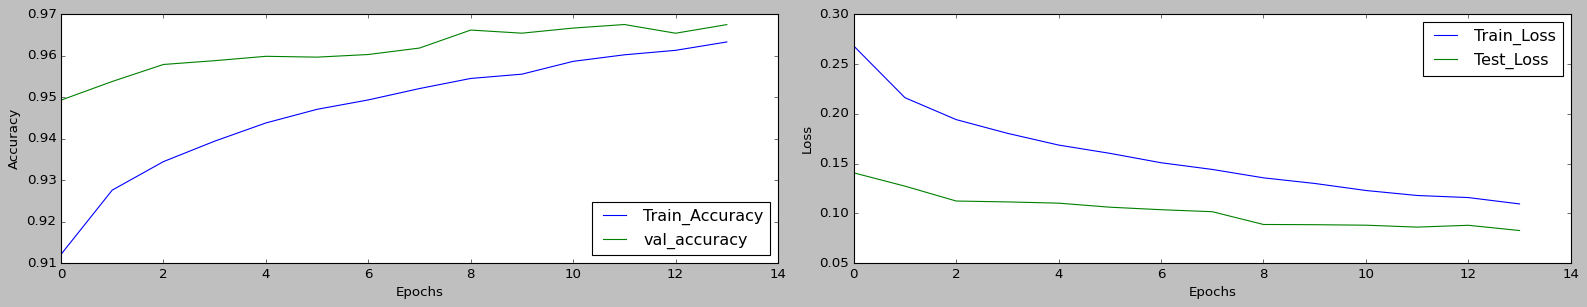

In [103]:
model_history_df = pd.DataFrame( model_history.history )

fg, ax = plt.subplots( 1,2, figsize= (20,4) )

# accuracy plots
ax[0].plot( model_history_df['accuracy'],  label = 'Train_Accuracy' )
ax[0].plot( model_history_df['val_accuracy'],  label = 'val_accuracy' )

# loss plots
ax[1].plot( model_history_df['loss'], label = 'Train_Loss' )
ax[1].plot( model_history_df['val_loss'], label = 'Test_Loss' )

ax[0].set_xlabel( 'Epochs' );   ax[0].set_ylabel( 'Accuracy' )
ax[1].set_xlabel( 'Epochs' );   ax[1].set_ylabel( 'Loss' )
ax[0].legend( loc= 'best' );  ax[1].legend( loc= 'best' )

plt.tight_layout(); plt.show()

#### Results

The CNN model after training has about 97% accuracy. Let’s see the confusion matrix which is a tabular representation often used to describe the performance of a classification model (or classifier) on a set of test data for which the true values are known.

14/14 [==============================] - 1s 42ms/step


<AxesSubplot:>

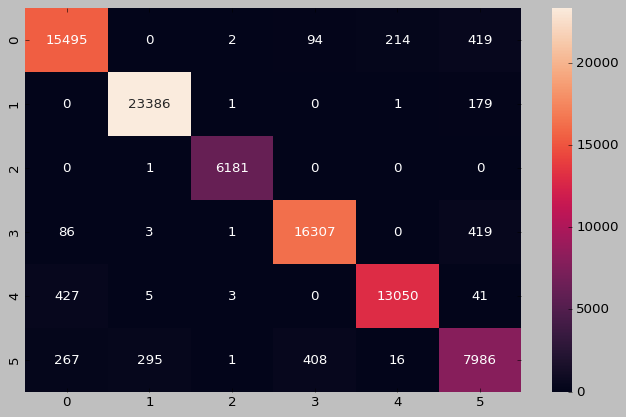

In [115]:
yhat = nn_model_1.predict( xtst, batch_size= 6*1024, verbose= 1 )

conf_mat = sklearn.metrics.confusion_matrix(  y_true= np.argmax( ytst, axis= 1 ),
                                              y_pred= np.argmax( yhat, axis= 1 )  )

# heatmap
plt.figure( figsize= (10,6) )
sns.heatmap( conf_mat, annot= True, fmt= 'd' )

plt.show()

In [118]:
# classification report

print(   sklearn.metrics.classification_report(  y_true= np.argmax( ytst, axis= 1 ),y_pred= np.argmax( yhat, axis= 1 )  )
     )

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     16224
           1       0.99      0.99      0.99     23567
           2       1.00      1.00      1.00      6182
           3       0.97      0.97      0.97     16816
           4       0.98      0.96      0.97     13526
           5       0.88      0.89      0.89      8973

    accuracy                           0.97     85288
   macro avg       0.96      0.96      0.96     85288
weighted avg       0.97      0.97      0.97     85288



#### visualize the classification map of the satellite data

40/40 [==============================] - 2s 50ms/step


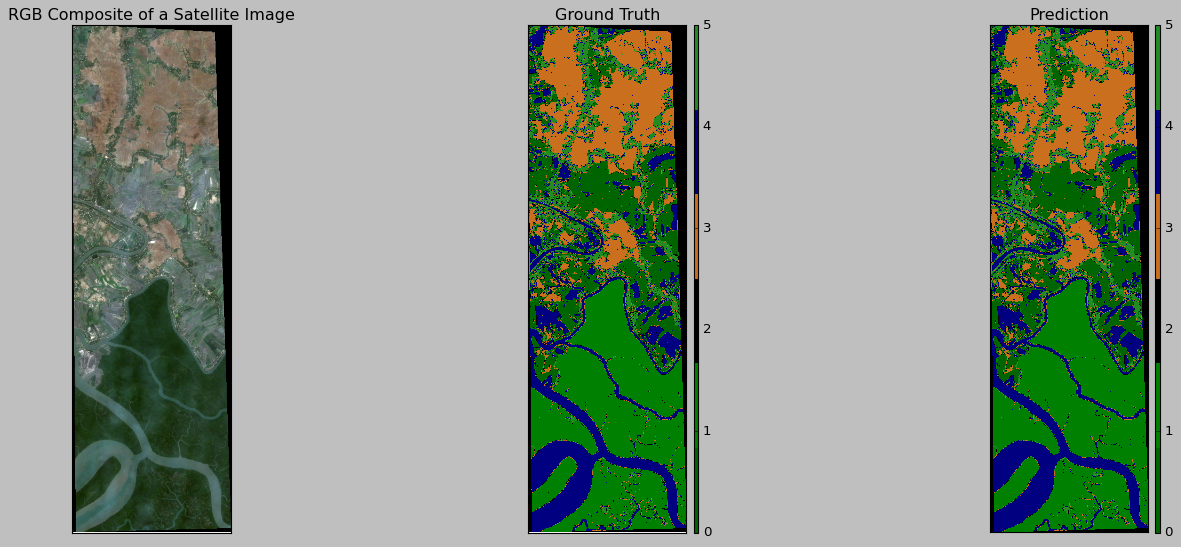

In [150]:
# prediction
yhat = nn_model_1.predict(  x= np.expand_dims( x_3D_patch, axis= -1 ), batch_size= 6*1204, verbose= 1  )
yhat_calc = np.argmax( yhat, axis= 1 )

# y label
yi_1 = loadmat( 'dataset/sundarbans_data/Sundarbands_gt.mat' )['gt'] 


fg, ax = plt.subplots( 1,3, figsize= ( 20, 7 ) )

# RGB imagery
ep.plot_rgb(    arr= raster_band_arr, rgb= (3,2,1), stretch= True, str_clip= 0.02, figsize=(8,10), title= 'RGB Composite of a Satellite Image', ax= ax[0]    )

# groud truth (label data)
ep.plot_bands(    yi_1, cmap= ListedColormap( colors= ['darkgreen', 'green', 'black','#CA6F1E', 'navy', 'forestgreen'] ), title= 'Ground Truth', ax= ax[1]    )

ep.plot_bands(    arr= yhat_calc.reshape( raster_band_arr_xyD.shape[:2] ), 
                  cmap= ListedColormap( ['darkgreen','green','black','#CA6F1E','navy','forestgreen']  ), title= 'Prediction', ax= ax[2]   )


plt.tight_layout(); plt.show()
